A benchark of underworld2, 2D subduction models
======
Guangliang Wu, guangliang.wu@unimelb.edu.au

The 2D subduction models corespond to case 1, with a weak lubricating layer, and case 2, without a lubricating layer by setting viscosity of the uppermost 'sticky air' weak layer to that of the upper mantle, models in Schmeling et al. (2008).

**Reference**:
Schmeling et al., 2008. PEPI 171, 198–223

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os
import datetime

/Users/glwu/underworld/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    modelStartTime = datetime.datetime.now()
uw.barrier()

**Setup model domain and resolution**


In [3]:
xRes = 256
yRes = 64
boxLength = 3000e3
boxHeight = 750e3
scaling   = 1e-14 # to make the sovler to be a little smooth; note that this is NOT nondimensionalization

**Create mesh and finite element variables**

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight),
                                 periodic    = [True, False] ) 

# Set velocity and pressure field as mesh variable
velocityField   = uw.mesh.MeshVariable( mesh = mesh,         nodeDofCount = 2 )
pressureField   = uw.mesh.MeshVariable( mesh = mesh.subMesh, nodeDofCount = 1 )

**Create a particle swarm**

In [5]:
particlesPerCell = 20

swarm              = uw.swarm.Swarm( mesh = mesh )
materialVariable   = swarm.add_variable( dataType="int", count=1 )
swarmLayout        = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm = swarm, particlesPerCell = particlesPerCell )
swarm.populate_using_layout( layout = swarmLayout )

# Create population control object to repolute swarm particles if needed
particleControls = uw.swarm.PopulationControl(swarm, aggressive = True, splitThreshold = 0.5,
                            maxDeletions = 0, maxSplits = 50, particlesPerCell = particlesPerCell)

**Allocate material types to particles**

In [6]:
# Initialise the 'materialVariable' data to represent two different materials. 
softLayerIndex   = 0
slabIndex        = 1
mantleIndex      = 2

# Initialise everying to be upper mantle material
materialVariable.data[:] = mantleIndex

# Set layout according to Fig. 1 in Schmeling et al., (2008)
softLayerY     = 700e3
slabShape = np.array([ (1000e3, 500e3), (1100e3,500e3 ), (1100e3,600e3),
                      (boxLength,600e3), (boxLength,700e3), (1000e3,700e3) ])
slab = fn.shape.Polygon( slabShape )

for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if coord[1] > softLayerY:
        materialVariable.data[index]     = softLayerIndex
    if slab.evaluate(tuple(coord)):
        materialVariable.data[index]     = slabIndex

**Plot the initial positions for the particle swarm and colour by material type**


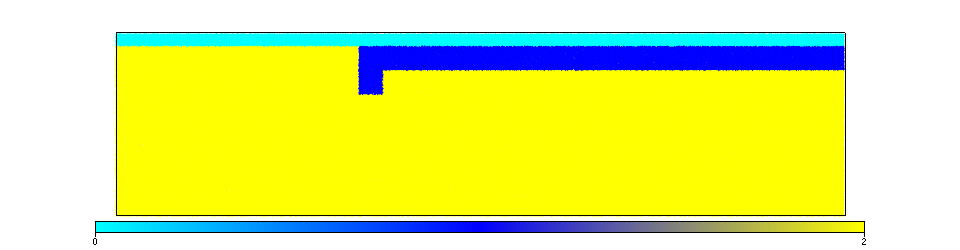

In [7]:
figParticle = glucifer.Figure(figsize=(960,250), name="Particles" )
figParticle.append( glucifer.objects.Points(swarm, materialVariable, pointSize=2, colours='cyan blue yellow') )
figParticle.show()

Set up material parameters and functions
----

Set functions for density, viscosity, gravity, and buoyancy. 

**Set viscosity function, and functions for strain rate, second invariant of strain rate, and deviatoric stress**

Note that for harmonic mean, first create a mesh variable to store reciprocal of viscosityFn, and project 1./viscosityFn onto the mesh variable, and then use the reciprocal of the mesh variable in the stokes system. One implementation is,

*meshViscosityReciprocal   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )*

*meshViscosityProjector = uw.utils.MeshVariable_Projection( meshViscosityReciprocal, 1./viscosityFn, type=0 )*

*meshViscosityProjector.solve()*

1./meshViscosityReciprocal is used intead of viscosityFn in the stokes system. *meshViscosityProjector.solve()* should be updated each time step. 

In [8]:
# The viscosity is simply constant. No yielding is used.
softLayerViscosity   =    1e19 # 1e19 Pa s for case 1 and 1e21 Pa s for case 2 in Schmeling et al. (2008)
slabViscosity        =    1e23
mantleViscosity      =    1e21

# Viscosity function for the materials
viscosityMap = { softLayerIndex   : softLayerViscosity, 
                 slabIndex        : slabViscosity, 
                 mantleIndex      : mantleViscosity     }
viscosityFn = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )

# Calculate strain rate and second invariant of strain rate
strainRateFn              = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant( strainRateFn )

# Calculate deviatoric stress (using Newtonian constitutive equation)
deviatoricStressFn = 2. * viscosityFn * strainRateFn

**Set density, gravity vector and buoyancy force**


In [9]:
softLayerDensity = 0.0
slabDensity      = 3300.0 # in kg/m^3
mantleDensity    = 3200.0

densityMap = { softLayerIndex : softLayerDensity, 
               slabIndex      : slabDensity, 
               mantleIndex    : mantleDensity }

densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Define our vertical unit vector using a python tuple
g = (0.0, -9.81 )

# Create a buoyancy force vector
buoyancyFn = densityFn * g

**Set initial and boundary conditions**

In [10]:
# set initial conditions (and boundary values)
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

# send boundary condition information to underworld
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]
topWall    = mesh.specialSets["MaxJ_VertexSet"]

# Free-slip boundary conditions for sidewalls, and top and bottom walls
freeSlipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )

**Set up stokes system, and attach a solver**

In [11]:
# Initiate the stokes system
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
#                                voronoi_swarm = swarm, # voronoi swarm with Q1 512 x 128
                               conditions    = [freeSlipBC, ],
                               fn_viscosity  = viscosityFn * scaling, 
                               fn_bodyforce  = buoyancyFn  * scaling )
# Create solver & solve
stokesSolver = uw.systems.Solver(stokes)

**Fine tune solver parameters**

In [12]:
# use "lu" direct solve if running in serial
if(uw.nProcs()==1):
    stokesSolver.set_inner_method("lu")
else:
    stokesSolver.set_inner_method('mumps')   # mumps is fast in 2D
    stokesSolver.set_penalty(1e6)            # large penalty can be used for mumps but not for mg
    stokesSolver.options.scr.ksp_type = 'cg'

**Set an advector for the swarm**

In [13]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

**Calculate root mean square velocity and pressure**

In [14]:
# The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )


# Pressure needs to be processed to remove effects of scaling and sticky air
surfaceArea             = uw.utils.Integral(fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=topWall)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField/scaling, mesh=mesh,
                                                integrationType='surface', surfaceIndexSet=topWall)

(area,) = surfaceArea.evaluate()
(p0,)   = surfacePressureIntegral.evaluate()
pressureField.data[:] = pressureField.data[:]/scaling - p0 / area

**Set preprocessing for saving data in h5 and xdmf, or for plot using glucifer**

In [15]:
# The stress is only guaranteed to be accurate when integrated across an element.
# Fluctuations within an element can be significant. Mapping to the mesh can help.
meshDevStress = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=3 )
meshDevStressProjector = uw.utils.MeshVariable_Projection( meshDevStress, deviatoricStressFn, type=0 )
meshDevStressProjector.solve()

# Project the second invariant of stain rate to mesh
meshStrainRateII = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
StrainRateIIProjector = uw.utils.MeshVariable_Projection( meshStrainRateII, strainRate_2ndInvariantFn, type=0 )
StrainRateIIProjector.solve()

# Project viscosity to mesh
meshRheology = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
meshRheologyProjector = uw.utils.MeshVariable_Projection( meshRheology, viscosityFn, type=0 )
meshRheologyProjector.solve()

# Project pressure to mesh
meshPressure = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
meshPressureProjector = uw.utils.MeshVariable_Projection( meshPressure, pressureField, type=0 )
meshPressureProjector.solve()

Main simulation loop
=======

The velocity field and pressure field are solved for via the Stokes system solver, and then the swarm is advected using the advector integrator. Basic logs of computation can be output if needed.

In [16]:
time = 0.           # Initial time
step = 0            # Initial timestep
maxSteps = 10       # Maximum timesteps; set to a small number for testing, say 201

# Set output frequency; set to a smaller number for testing, say 5
outputFrequency = 5 # Number of time steps
kyr = 1000. * 365. * 24. * 60. * 60. # kyr in seconds

# Save the mesh to h5 file
meshFileHandle = mesh.save(outputPath + 'mesh.h5')

In [17]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system
    dt = advector.get_max_dt()
    # Advect using this timestep size.
    advector.integrate(dt)
    particleControls.repopulate()
    
    # Print out logs of interest
    if uw.rank()==0 and step % outputFrequency == 0:
        now = datetime.datetime.now()
        print('Step No.    = ' + str(step) + '; Current clock time = ' + 
              str(now) + '; Model wall time passing = ' + str(now - modelStartTime) )
        print('Time step   = ' + str('{:0.5f}'.format(dt/kyr)) + 'kyr')
        print('Model Time  = ' + str('{:09.7f}'.format(time/(1000.*kyr)) + 'Myr'))
        print('Vrms = {:.3e}'.format(Vrms) )
        
    return time + dt, step + 1

In [18]:
while step < maxSteps:
    # Solve non linear Stokes system
    stokesSolver.solve( nonLinearIterate=False )
   
    # update pressure
    (area,) = surfaceArea.evaluate()
    (p0,)   = surfacePressureIntegral.evaluate()
    pressureField.data[:] = pressureField.data[:]/scaling - p0 / area
    
    # output figure to file at intervals = steps_output
    if step % outputFrequency == 0 or step == maxSteps - 1:

#         figParticle.save(    outputPath + "particle"    + str(step).zfill(4))
#         figVelocityMag.save( outputPath + "velocityMag" + str(step).zfill(4))
#         figStrainRate.save(  outputPath + "strainRate"  + str(step).zfill(4))
#         figViscosity.save(   outputPath + "viscosity"   + str(step).zfill(4))
#         figStress.save(      outputPath + "stress"      + str(step).zfill(4))


        # To save in h5 and xdmf for viewing in ParaView, VisIt, or other software
        meshDevStressProjector.solve()
        StrainRateIIProjector.solve()
        meshRheologyProjector.solve()
        meshPressureProjector.solve()
        
        modelTime = str('{:2.4f}'.format(time/3.1536e15)) # Model time in 100 Myr

        #Velocity
        velFilename = outputPath + 'velocityField-' + modelTime + '.xdmf'
        velHnd = velocityField.save(outputPath + 'velocityField-' + modelTime +'.h5',
                                    meshFileHandle)
        velocityField.xdmf(velFilename, velHnd, "VelField", meshFileHandle,
                           'TheMesh', modeltime=time)

        # strain rate II
        strainRateIIFilename = outputPath + 'strainRateII-' + modelTime + '.xdmf'
        strainRateIIHnd = meshStrainRateII.save(outputPath + 'strainRateII-' + 
                                                modelTime + '.h5', meshFileHandle)
        meshStrainRateII.xdmf(strainRateIIFilename, strainRateIIHnd, 'strainRateII',
                              meshFileHandle, 'TheMesh', modeltime=time)

        # rheology on mesh
        meshRheologyFilename = outputPath + 'rheology-' + modelTime + '.xdmf'
        meshRheologyHnd = meshRheology.save(outputPath + 'rheology-' +
                                            modelTime + '.h5', meshFileHandle)
        meshRheology.xdmf(meshRheologyFilename, meshRheologyHnd, 'rheology',
                              meshFileHandle, 'TheMesh', modeltime=time)

        # pressure on mesh
        meshPressureFilename = outputPath + 'pressure-' + modelTime + '.xdmf'
        meshPressureHnd = meshPressure.save(outputPath + 'pressure-' + 
                                            modelTime + '.h5', meshFileHandle)
        meshPressure.xdmf(meshPressureFilename, meshPressureHnd, 'pressure',
                              meshFileHandle, 'TheMesh', modeltime=time)

        # stress on mesh
        stressFilename = outputPath + 'devStress-' + modelTime + '.xdmf'
        stressHnd = meshDevStress.save(outputPath + 'devStress-' + 
                                       modelTime + '.h5', meshFileHandle)
        meshDevStress.xdmf(stressFilename, stressHnd, 'devStress',
                           meshFileHandle, "TheMesh", modeltime=time)

        # SAVING SWARM VARIABLES FOR VISUALIZATION IN PARAVIEW
        swarmFileHandle = swarm.save(outputPath + 'swarm-' + modelTime + '.h5')

        # material index
        phaseFilename =  outputPath + 'phase-' + modelTime + '.xdmf'
        phaseHnd = materialVariable.save(outputPath + 'phase-' 
                                         + modelTime + '.h5')
        materialVariable.xdmf(phaseFilename, phaseHnd, 'materialVariable', 
                              swarmFileHandle, 'TheSwarm', modeltime=time)

    uw.barrier()
        
    # update
    time,step = update()

Step No.    = 0; Current clock time = 2019-09-13 13:57:25.421322; Model wall time passing = 0:00:21.749540
Time step   = 9.21984kyr
Model Time  = 0.0000000Myr
Vrms = 0.000e+00
Step No.    = 5; Current clock time = 2019-09-13 13:57:45.840702; Model wall time passing = 0:00:42.168920
Time step   = 20.02985kyr
Model Time  = 0.0558833Myr
Vrms = 0.000e+00


**For demonstraton purposes, we show results for various variables at final step**


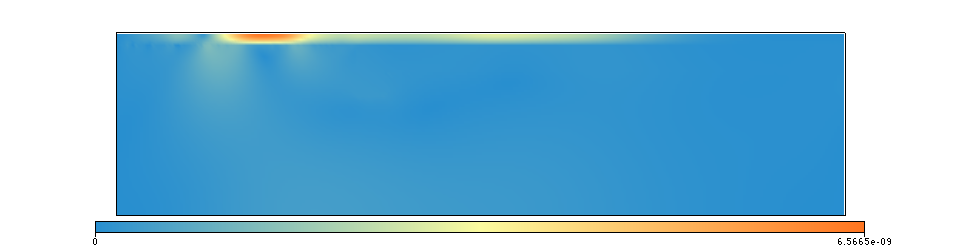


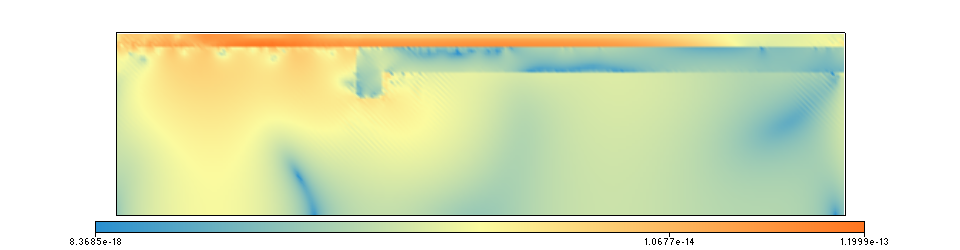


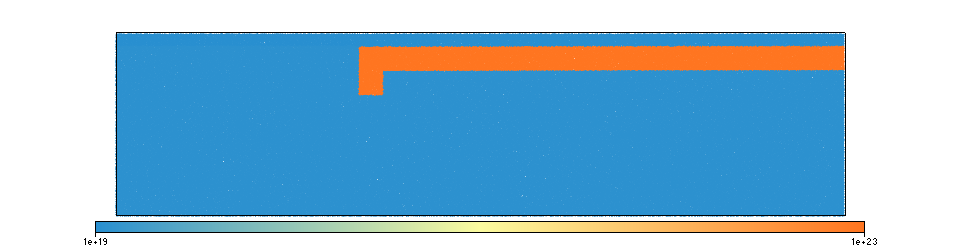


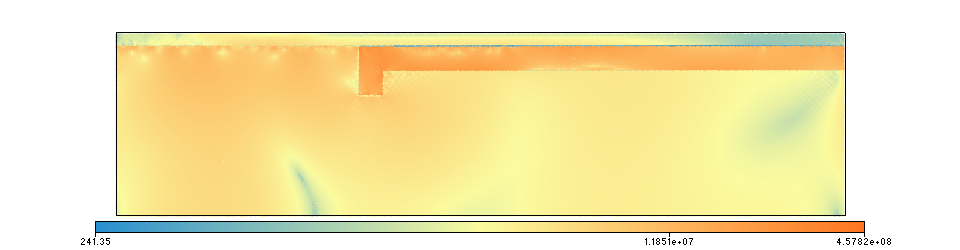

In [19]:
# Plot of Velocity Magnitude
figVelocityMag = glucifer.Figure(figsize=(960,250))
figVelocityMag.append( glucifer.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField,velocityField))) )
figVelocityMag.show()

# Plot of Strain Rate, 2nd Invariant
figStrainRate = glucifer.Figure(figsize=(960,250))
figStrainRate.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariantFn, logScale=True) )
figStrainRate.show()

# Plot of particles viscosity
figViscosity = glucifer.Figure(figsize=(960,250))
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, pointSize=2) )
figViscosity.show()

# Plot of particles stress invariant
figStress = glucifer.Figure(figsize=(960,250) )
figStress.append( glucifer.objects.Points(swarm, 2. * viscosityFn * strainRate_2ndInvariantFn,
                                          pointSize=2, logScale=True) )
figStress.show()

Post processing
----

Post processing can be done in many ways. We show results of Case 1 in Schmeling et al. (2008) we run using arithmetic mean or harmonic mean for viscosity. Resolution of the model is 512 x 128, with 50 swarm particles per cell. Viscosity of the soft layer is 1e19 Pa s.

**Subduction slab depth through time**

In [20]:
# We prepare data for slab tip for case 1 based on output from h5 and xdmf files viewed in ParaView
slabTip1 = np.loadtxt(outputPath + "amDepth.txt", skiprows=0)
slabTip2 = np.loadtxt(outputPath + "hmDepth.txt", skiprows=0)
modelTime1 = slabTip1[:,0]/3.1536e13 # time in Myr
modelTime2 = slabTip2[:,0]/3.1536e13
depth1 = -( slabTip1[:,1] - 700.) # Depth in km
depth2 = -( slabTip2[:,1] - 700.)

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

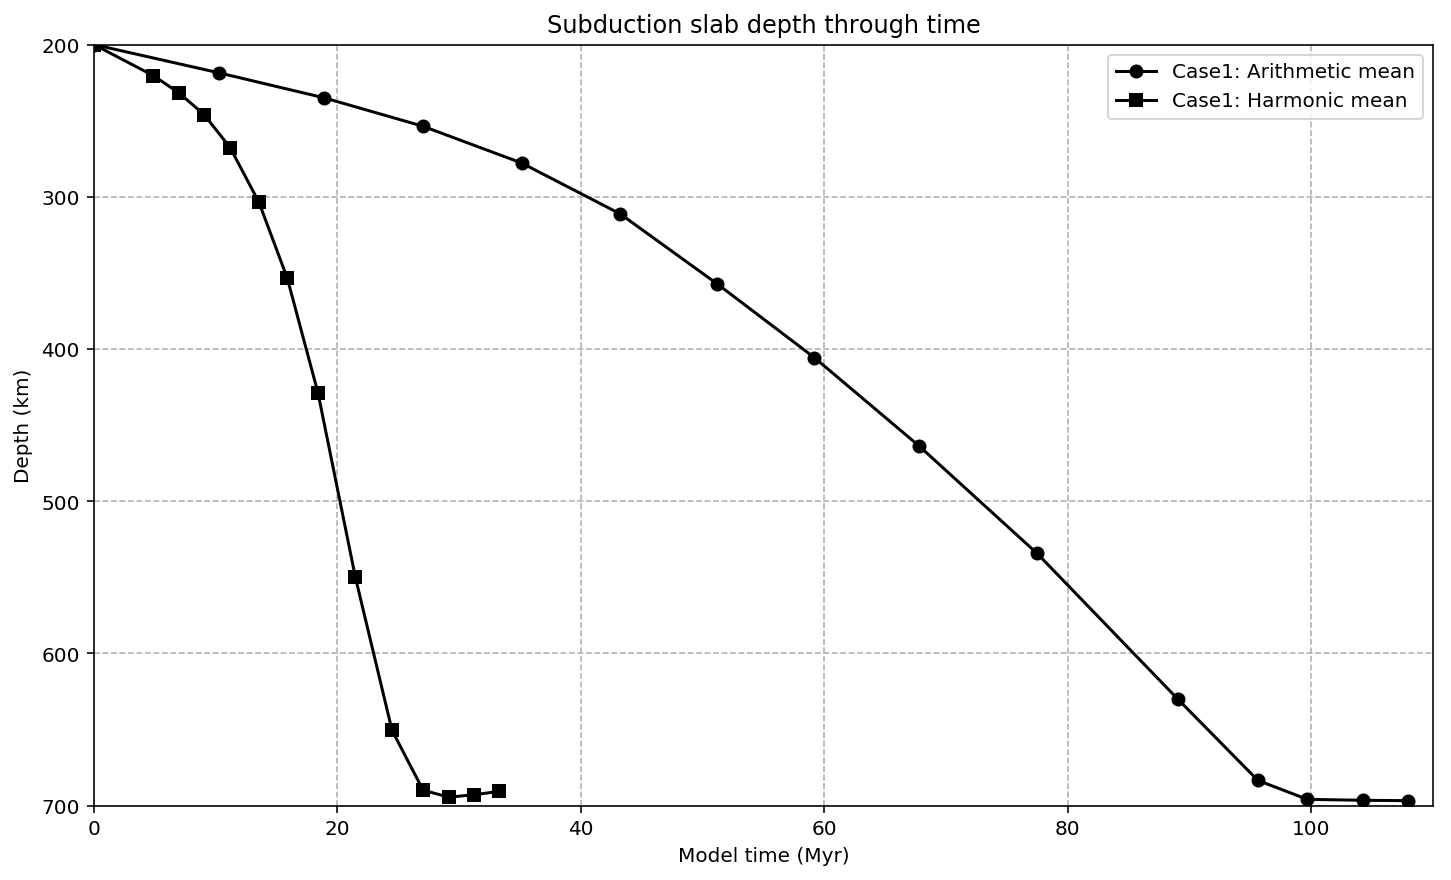

In [22]:
%config InlineBackend.figure_format = 'retina' # use this line if using retina display, otherwise comment it out
plt.figure(figsize=(12,7))
plt.plot(modelTime1, depth1, '-ko', label='Case1: Arithmetic mean')
plt.plot(modelTime2, depth2, '-ks', label='Case1: Harmonic mean')
plt.xlim(0,110) # Show 0-110 Myr
plt.ylim(700,200)
plt.grid(linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('Model time (Myr)')
plt.ylabel('Depth (km)')
plt.title('Subduction slab depth through time')
plt.show()

**Subduction evolution through time**

#### Case 1: Arithmetic mean

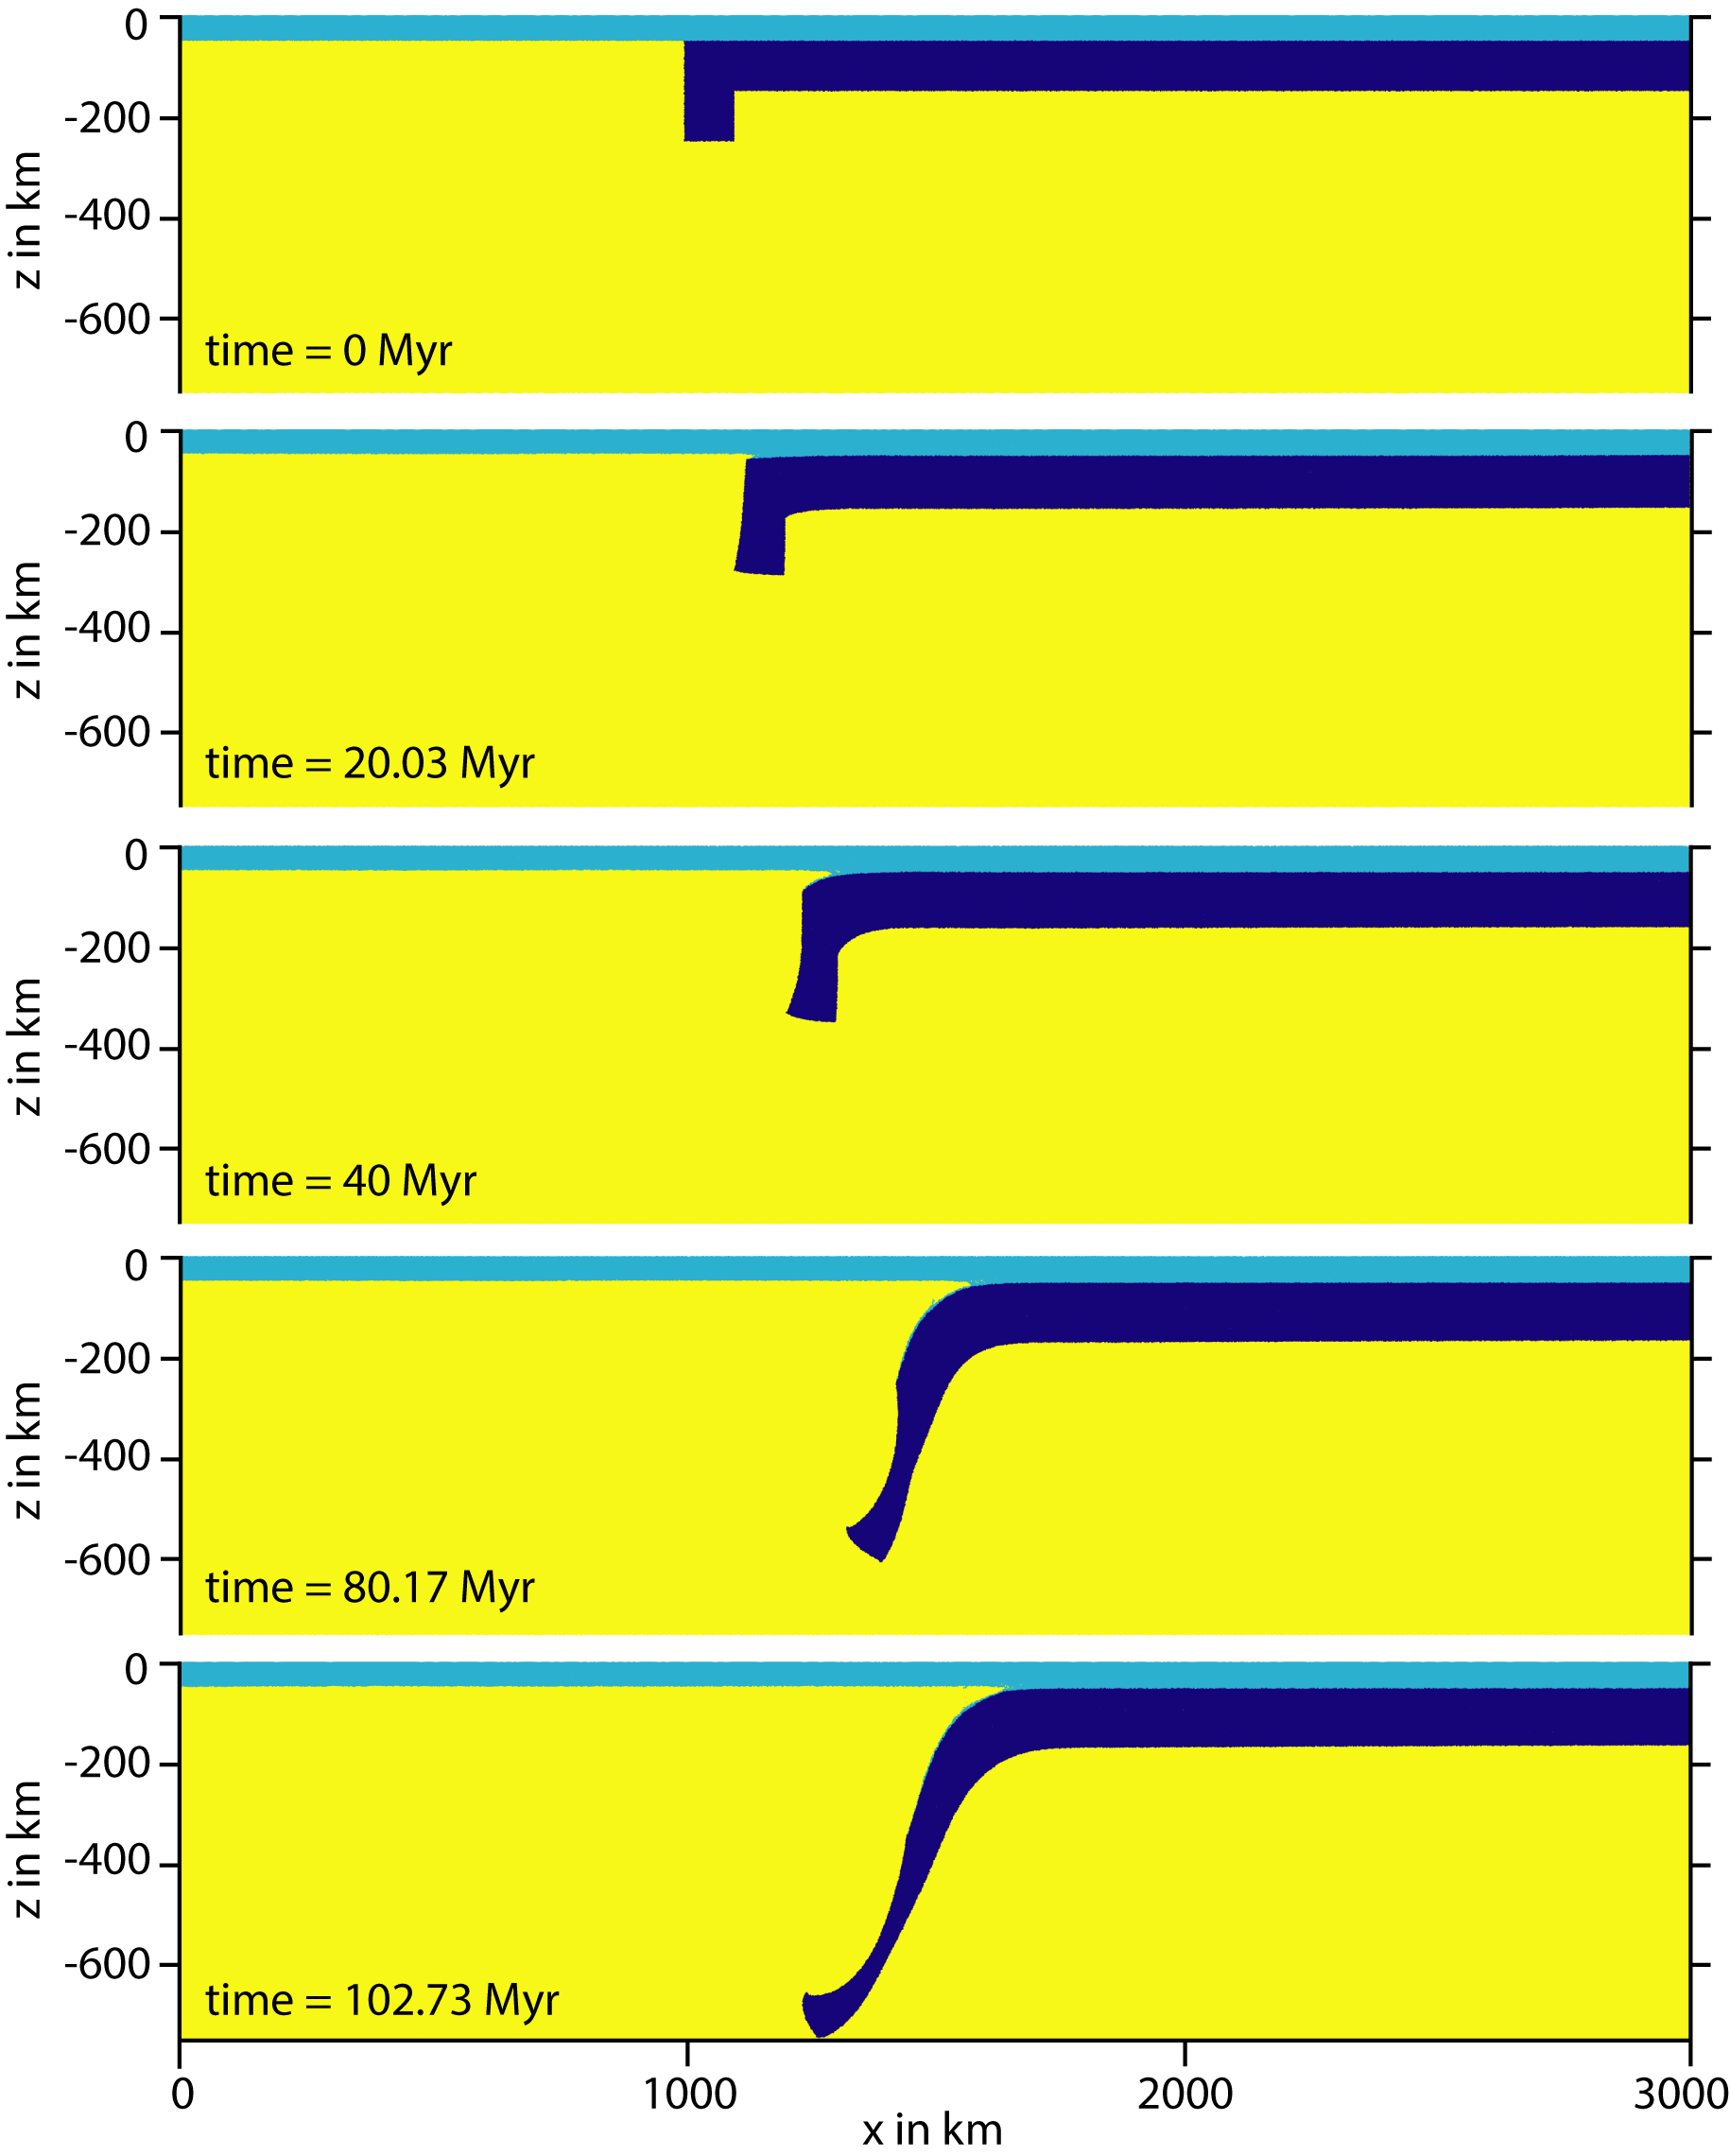

In [23]:
from IPython.display import Image
Image(outputPath + "case1_arithmeticMean.png")

#### Case 1: Harmonic mean

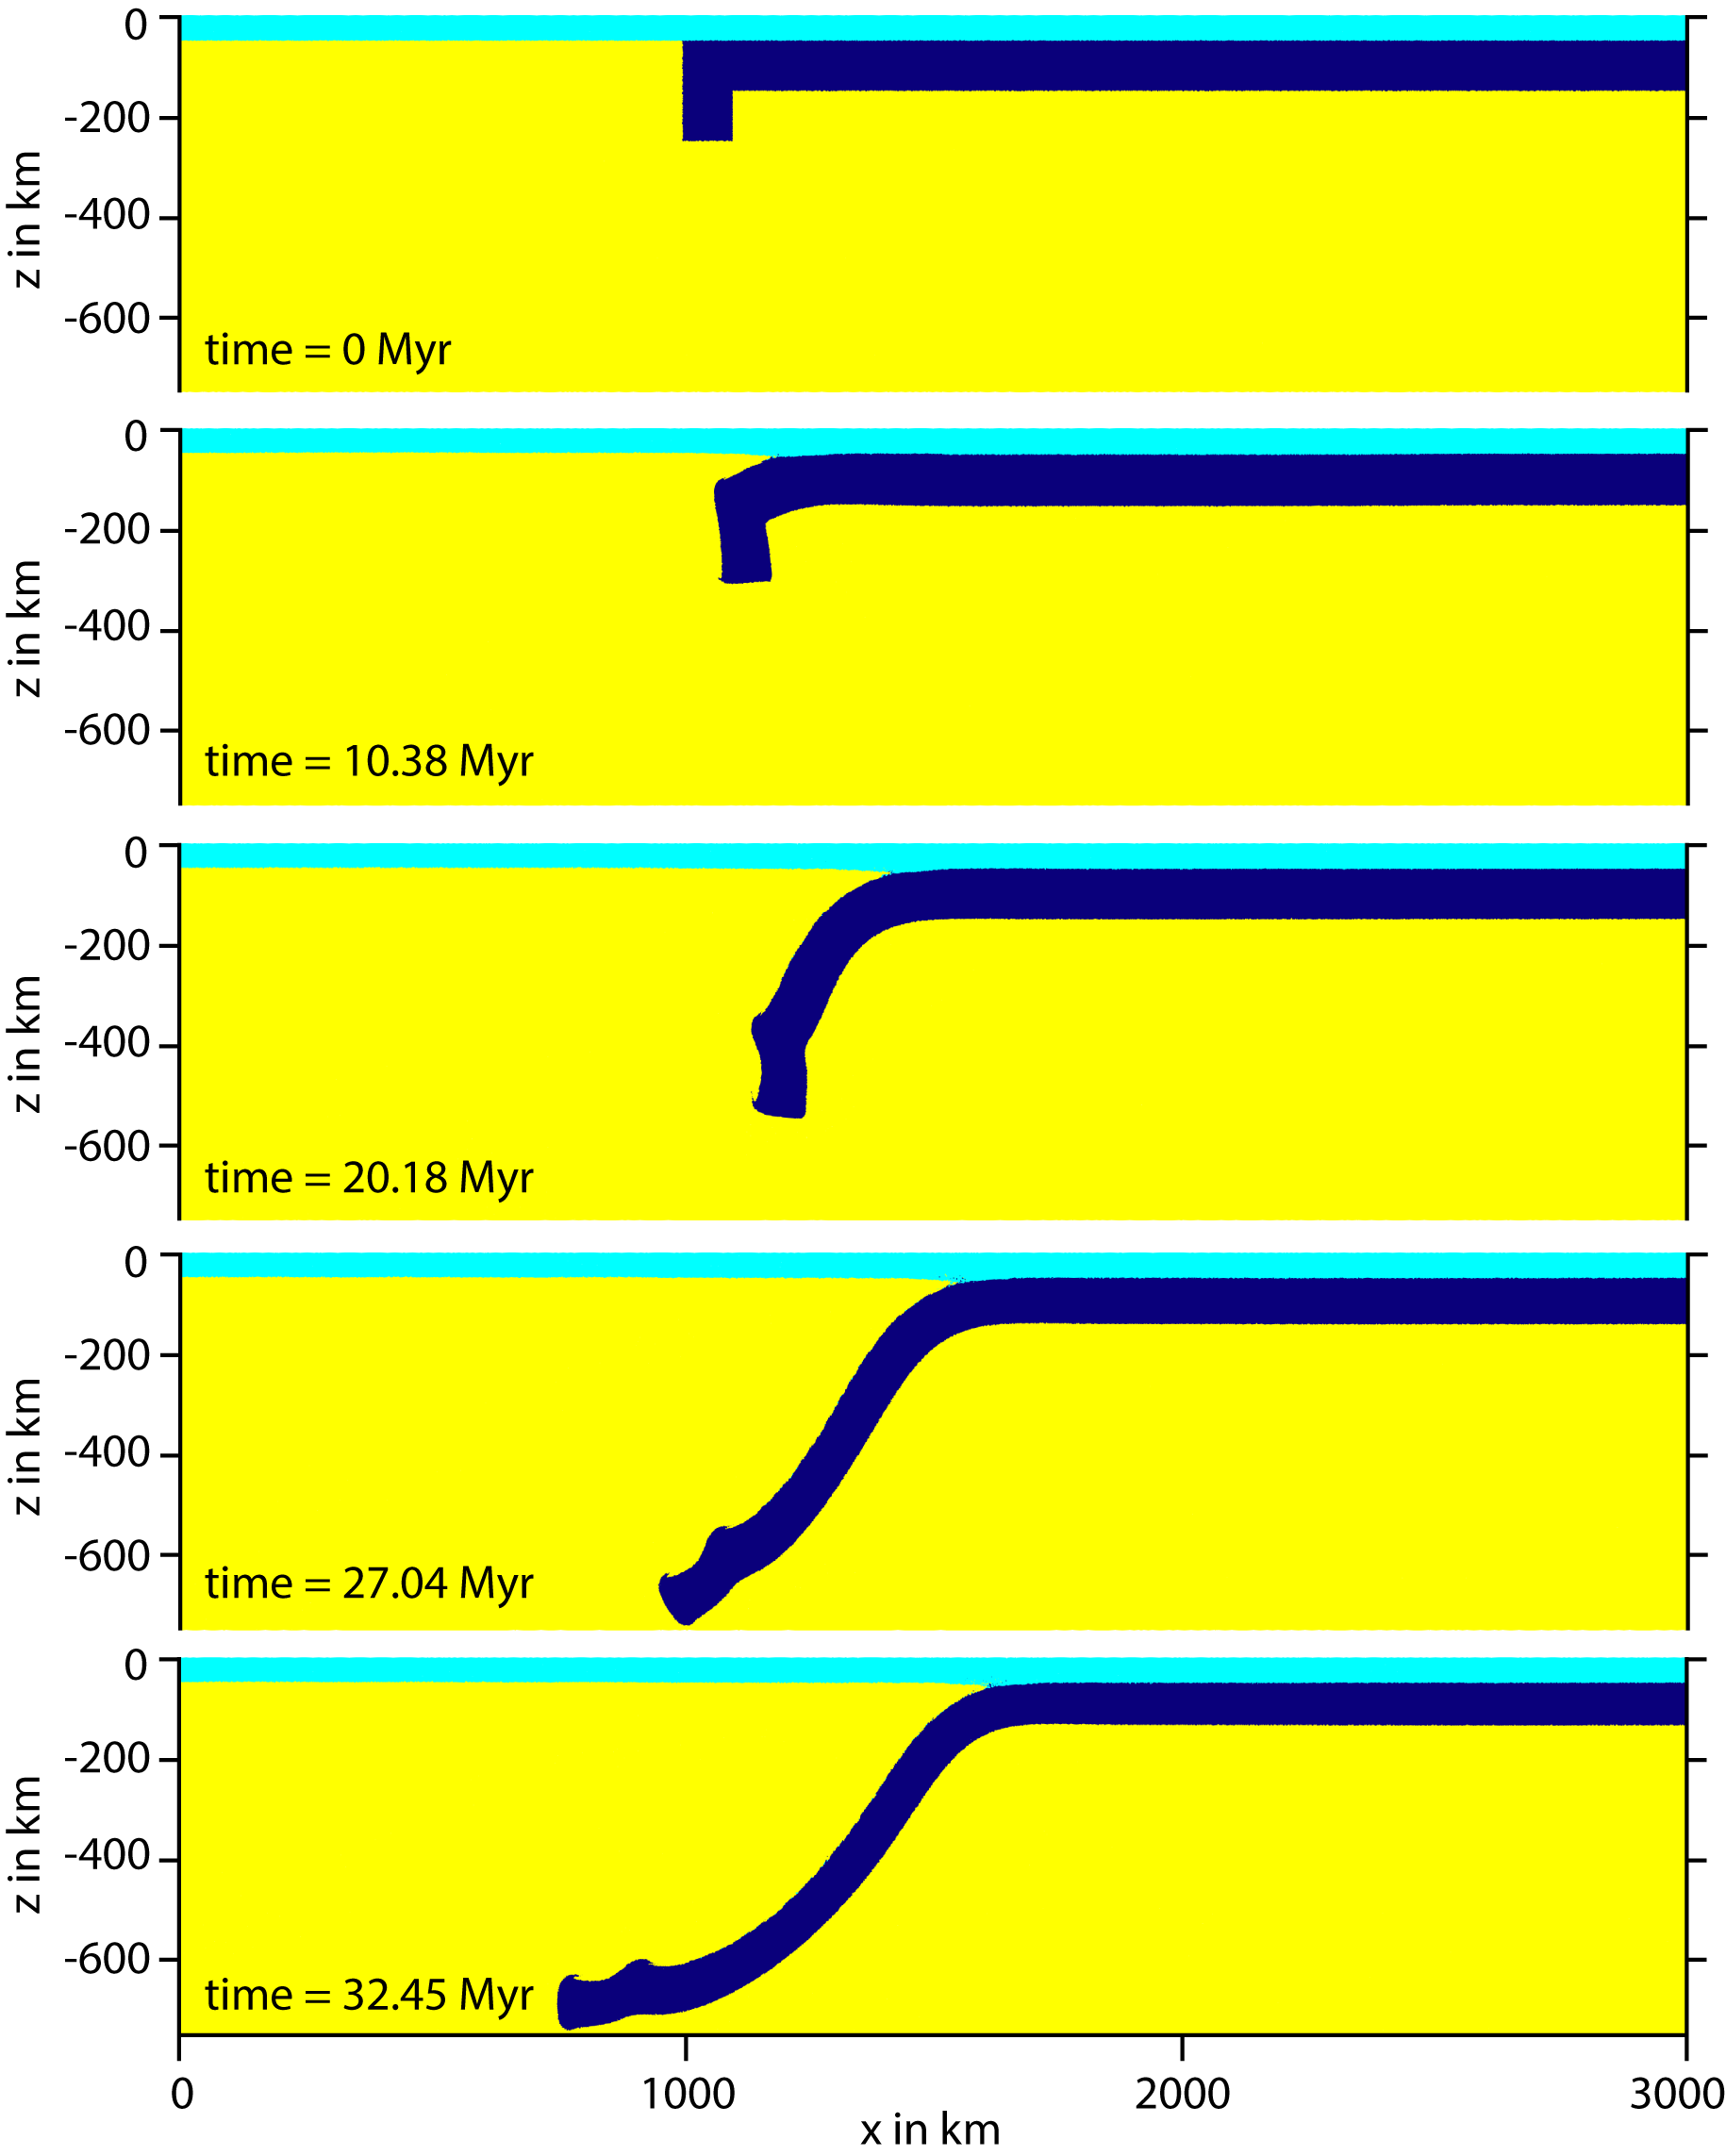

In [24]:
Image(outputPath + "case1_harmonicMean.png")